In [4]:
import numpy as np

In [2]:
x = [111.74895025, 110.60431817, 115.28335826, 130.78237675, 123.92276732,
 113.89210051,  96.34180979]

In [5]:
x = np.round(x).astype(int)

In [6]:
x

array([112, 111, 115, 131, 124, 114,  96])

In [7]:
N = len(x)
xbar = np.sum(x) / N
vbar = np.sum(x**2) / N - xbar**2

In [8]:
print(N, xbar, vbar)

7 114.71428571428571 103.34693877551217


In [9]:
mu_map = xbar
sigma2_map = N/(N+2) * vbar
print(mu_map, sigma2_map)

114.71428571428571 80.38095238095391


### MAP + Laplace

In [96]:
stdL_mu = np.sqrt(vbar / (N+2))
print(stdL_mu)

3.3886565475537838


In [98]:
map_sigma2 = N*vbar / (N+2)
print(map_sigma2)

80.38095238095391


In [97]:
stdL_sigma2 = np.sqrt(2/(N+2)) * (N*vbar) / (N+2)
print(stdL_sigma2)

37.891944337870314


In [12]:
from scipy.stats import norm

In [18]:
norm.cdf(100, loc=114.71, scale=3.3887)

7.095089435986842e-06

### MCMC

In [24]:
import pystan
import matplotlib.pyplot as plot
%matplotlib inline

In [20]:
model_code = """
data {
    int<lower=1> N;
    real x[N];
}
parameters {
    real mu;
    real<lower=0> sigma2;
}
model {
    target += -log(sigma2);
    for (n in 1:N){
        target += normal_lpdf(x[n] | mu, sqrt(sigma2));
    }
}
"""
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8258f59d6e75123ee1a9430584891913 NOW.


In [21]:
data = {'N': N, 'x': x}

In [60]:
fit = model.sampling(data=data, iter=100_000, seed=123456, thin=10)

In [61]:
samples = fit.extract()

In [62]:
samples

OrderedDict([('mu',
              array([119.23472989, 118.66812465, 110.36787915, ..., 119.30141816,
                     110.27431963, 115.03330865])),
             ('sigma2',
              array([ 73.50724632, 107.25410408, 150.34284013, ..., 195.98167421,
                     188.5753281 ,  81.21736506])),
             ('lp__',
              array([-27.36718284, -26.6784141 , -26.82350396, ..., -27.12707867,
                     -27.0548365 , -26.28056445]))])

In [63]:
np.mean(samples['mu'])

114.69473887933707

In [64]:
np.std(samples['mu'])

5.070634003746407

In [66]:
np.median(samples['mu'])

114.6858418181972

In [67]:
np.mean(samples['sigma2'])

179.3913417847036

In [68]:
np.median(samples['sigma2'])

135.87307292770845

In [69]:
np.std(samples['sigma2'])

164.42412608441975

In [70]:
Cov = np.cov(samples['mu'], samples['sigma2'])
print(Cov)

[[2.57126148e+01 1.16145300e+01]
 [1.16145300e+01 2.70366451e+04]]


In [71]:
corr = Cov[0,1] / np.sqrt(Cov[0,0] * Cov[1,1])

In [72]:
corr

0.013930032151385916

In [73]:
np.sum(samples['mu'] < 100)

117

In [74]:
len(samples['mu'])

20000

In [75]:
np.sum(samples['mu'] < 100) / len(samples['mu'])

0.00585

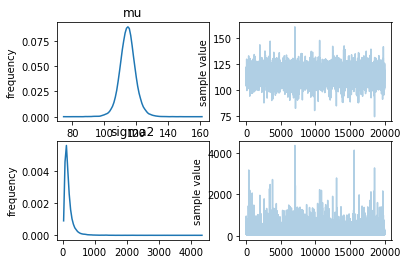

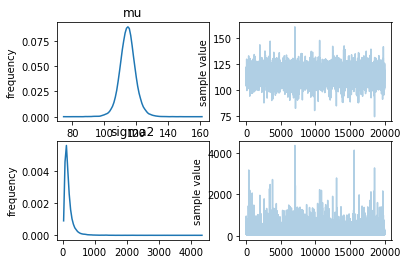

In [76]:
fit.plot()

### Exact

In [78]:
xbar

114.71428571428571

In [79]:
np.sqrt(vbar / (N-3))

5.082984821330676

In [80]:
N*vbar / (N-3)

180.8571428571463

In [81]:
N*vbar / (N+2)

80.38095238095391

In [85]:
np.sqrt(2)*N*vbar / (N-2) / np.sqrt(N-5)

144.68571428571704

In [89]:
from scipy.stats import t as tdist

In [94]:
tdist.cdf(100, df=N-1, loc=xbar, scale=np.sqrt(vbar / (N-1)))

0.006069634639077216

### Comparison

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

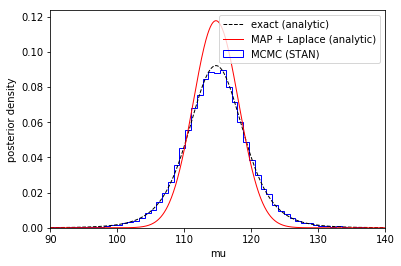

In [132]:
plt.figure(figsize=(6,4))
x = np.linspace(90, 140, 1000)
plt.plot(x, tdist.pdf(x, df=N-1, loc=xbar, scale=np.sqrt(vbar / (N-1))), 
         'k--', lw=1, label='exact (analytic)')
plt.plot(x, norm.pdf(x, loc=xbar, scale=stdL_mu), 
         'r-', lw=1, label='MAP + Laplace (analytic)')
plt.hist(samples['mu'], 
         color='b', bins=100,
         density=True, label='MCMC (STAN)', histtype='step')


plt.xlabel('mu')
plt.ylabel('posterior density')
plt.xlim([90,140])
plt.legend()

plt.savefig('./P3_mu_posterior.pdf', bbox_inches='tight')
plt.show()

In [120]:
from scipy.stats import invgamma

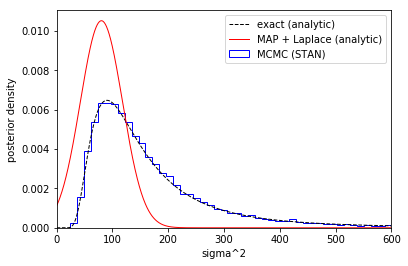

In [131]:
plt.figure(figsize=(6,4))
x = np.linspace(0, 600, 1000)
plt.plot(x, invgamma.pdf(x, a=(N-1)/2, scale=N*vbar/2), 
         'k--', lw=1, label='exact (analytic)')
plt.plot(x, norm.pdf(x, loc=map_sigma2, scale=stdL_sigma2), 
         'r-', lw=1, label='MAP + Laplace (analytic)')
plt.hist(samples['sigma2'], 
         color='b', bins=np.linspace(0,600,50),
         density=True, label='MCMC (STAN)', histtype='step')


plt.xlabel('sigma^2')
plt.ylabel('posterior density')
plt.xlim([0,600])
plt.legend()

plt.savefig('./P3_sigma2_posterior.pdf', bbox_inches='tight')
plt.show()

In [133]:
from scipy.special import gamma

In [173]:
from scipy.stats import multivariate_normal

In [170]:
multivariate_normal?

In [227]:
from scipy.stats import gaussian_kde

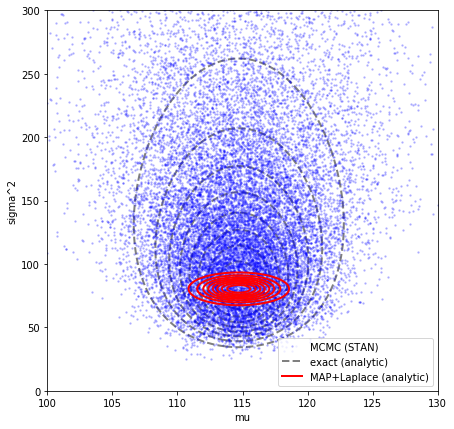

In [255]:
mu_grid = np.linspace(100, 130, 300)
sigma2_grid = np.linspace(0.0001, 300, 300)
mu, sigma2 = np.meshgrid(mu_grid, sigma2_grid)
Zexact = (
    np.sqrt(N / (2*np.pi*sigma2)) 
     / gamma((N-1)/2) 
     * ((N*vbar)/2)**((N-1)/2)
     * sigma2**(-(N+1)/2)
     * np.exp(-(N*vbar + N*(mu - xbar)**2) / (2*sigma2))
    )

xy = np.zeros([len(mu_grid), len(sigma2_grid), 2])
xy[:, :, 0] = mu
xy[:, :, 1] = sigma2
xy_mean = np.array([xbar, map_sigma2])
xy_cov = np.array([[stdL_mu, 0], [0, stdL_sigma2]])
ZLaplace = multivariate_normal.pdf(xy, mean=xy_mean, cov=xy_cov)


plt.figure(figsize=(7,7))

plt.plot(samples['mu'], samples['sigma2'], 
         'b.', ms=3, alpha=0.2,
         label='MCMC (STAN)')

levels = np.linspace(0, np.max(Zexact), 10)
plt.contour(mu, sigma2, Zexact, levels, 
            linewidths=2, linestyles='--', colors='gray', zorder=1)
plt.plot([],[], ls='--', lw=2, color='gray', 
         label='exact (analytic)')

levels = np.linspace(0, np.max(ZLaplace), 10)
plt.contour(mu, sigma2, ZLaplace, levels, 
            linewidths=2, linestyles='-', colors='red', zorder=3)
plt.plot([],[], ls='-', lw=2, color='red', 
         label='MAP+Laplace (analytic)')

# kernel = gaussian_kde([samples['mu'], samples['sigma2']])
# Zkde = np.zeros([len(mu_grid), len(sigma2_grid)])
# for i in range(len(mu_grid)):
#     for j in range(len(sigma2_grid)):
#         Zkde[j, i] = kernel.evaluate([mu_grid[i], sigma2_grid[j]])
# levels = np.linspace(0, np.max(Zkde), 10)
# plt.contour(mu, sigma2, Zkde, levels, 
#             linewidths=1, linestyles='-', colors='blue')
# plt.plot([],[], ls='-', lw=1, color='blue', 
#          label='MCMC-kde (STAN)')





plt.xlim([100, 130])
plt.ylim([0, 300])
plt.xlabel('mu')
plt.ylabel('sigma^2')
plt.legend()


plt.savefig('P3_joint_posterior.pdf', bbox_inches='tight')

plt.show()

In [228]:
gaussian_kde

In [207]:
levels

array([0.        , 0.00155756, 0.00311513, 0.00467269, 0.00623026,
       0.00778782, 0.00934539, 0.01090295, 0.01246052, 0.01401808])

In [193]:
np.max(ZLaplace)

0.00019090174608054068

In [230]:
kernel?

In [199]:
np.sum(ZLaplace)

6.886022448913438

In [215]:
xbar

114.71428571428571